In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler


df = pd.read_csv('../DATASETS/magic04_gamma.csv')
df.head()
# Drop the ID Column
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


/home/shahjahan/anaconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
# Check the class distribution
val = df['class'].value_counts()
val['g'] / val['h']

1.8438995215311005

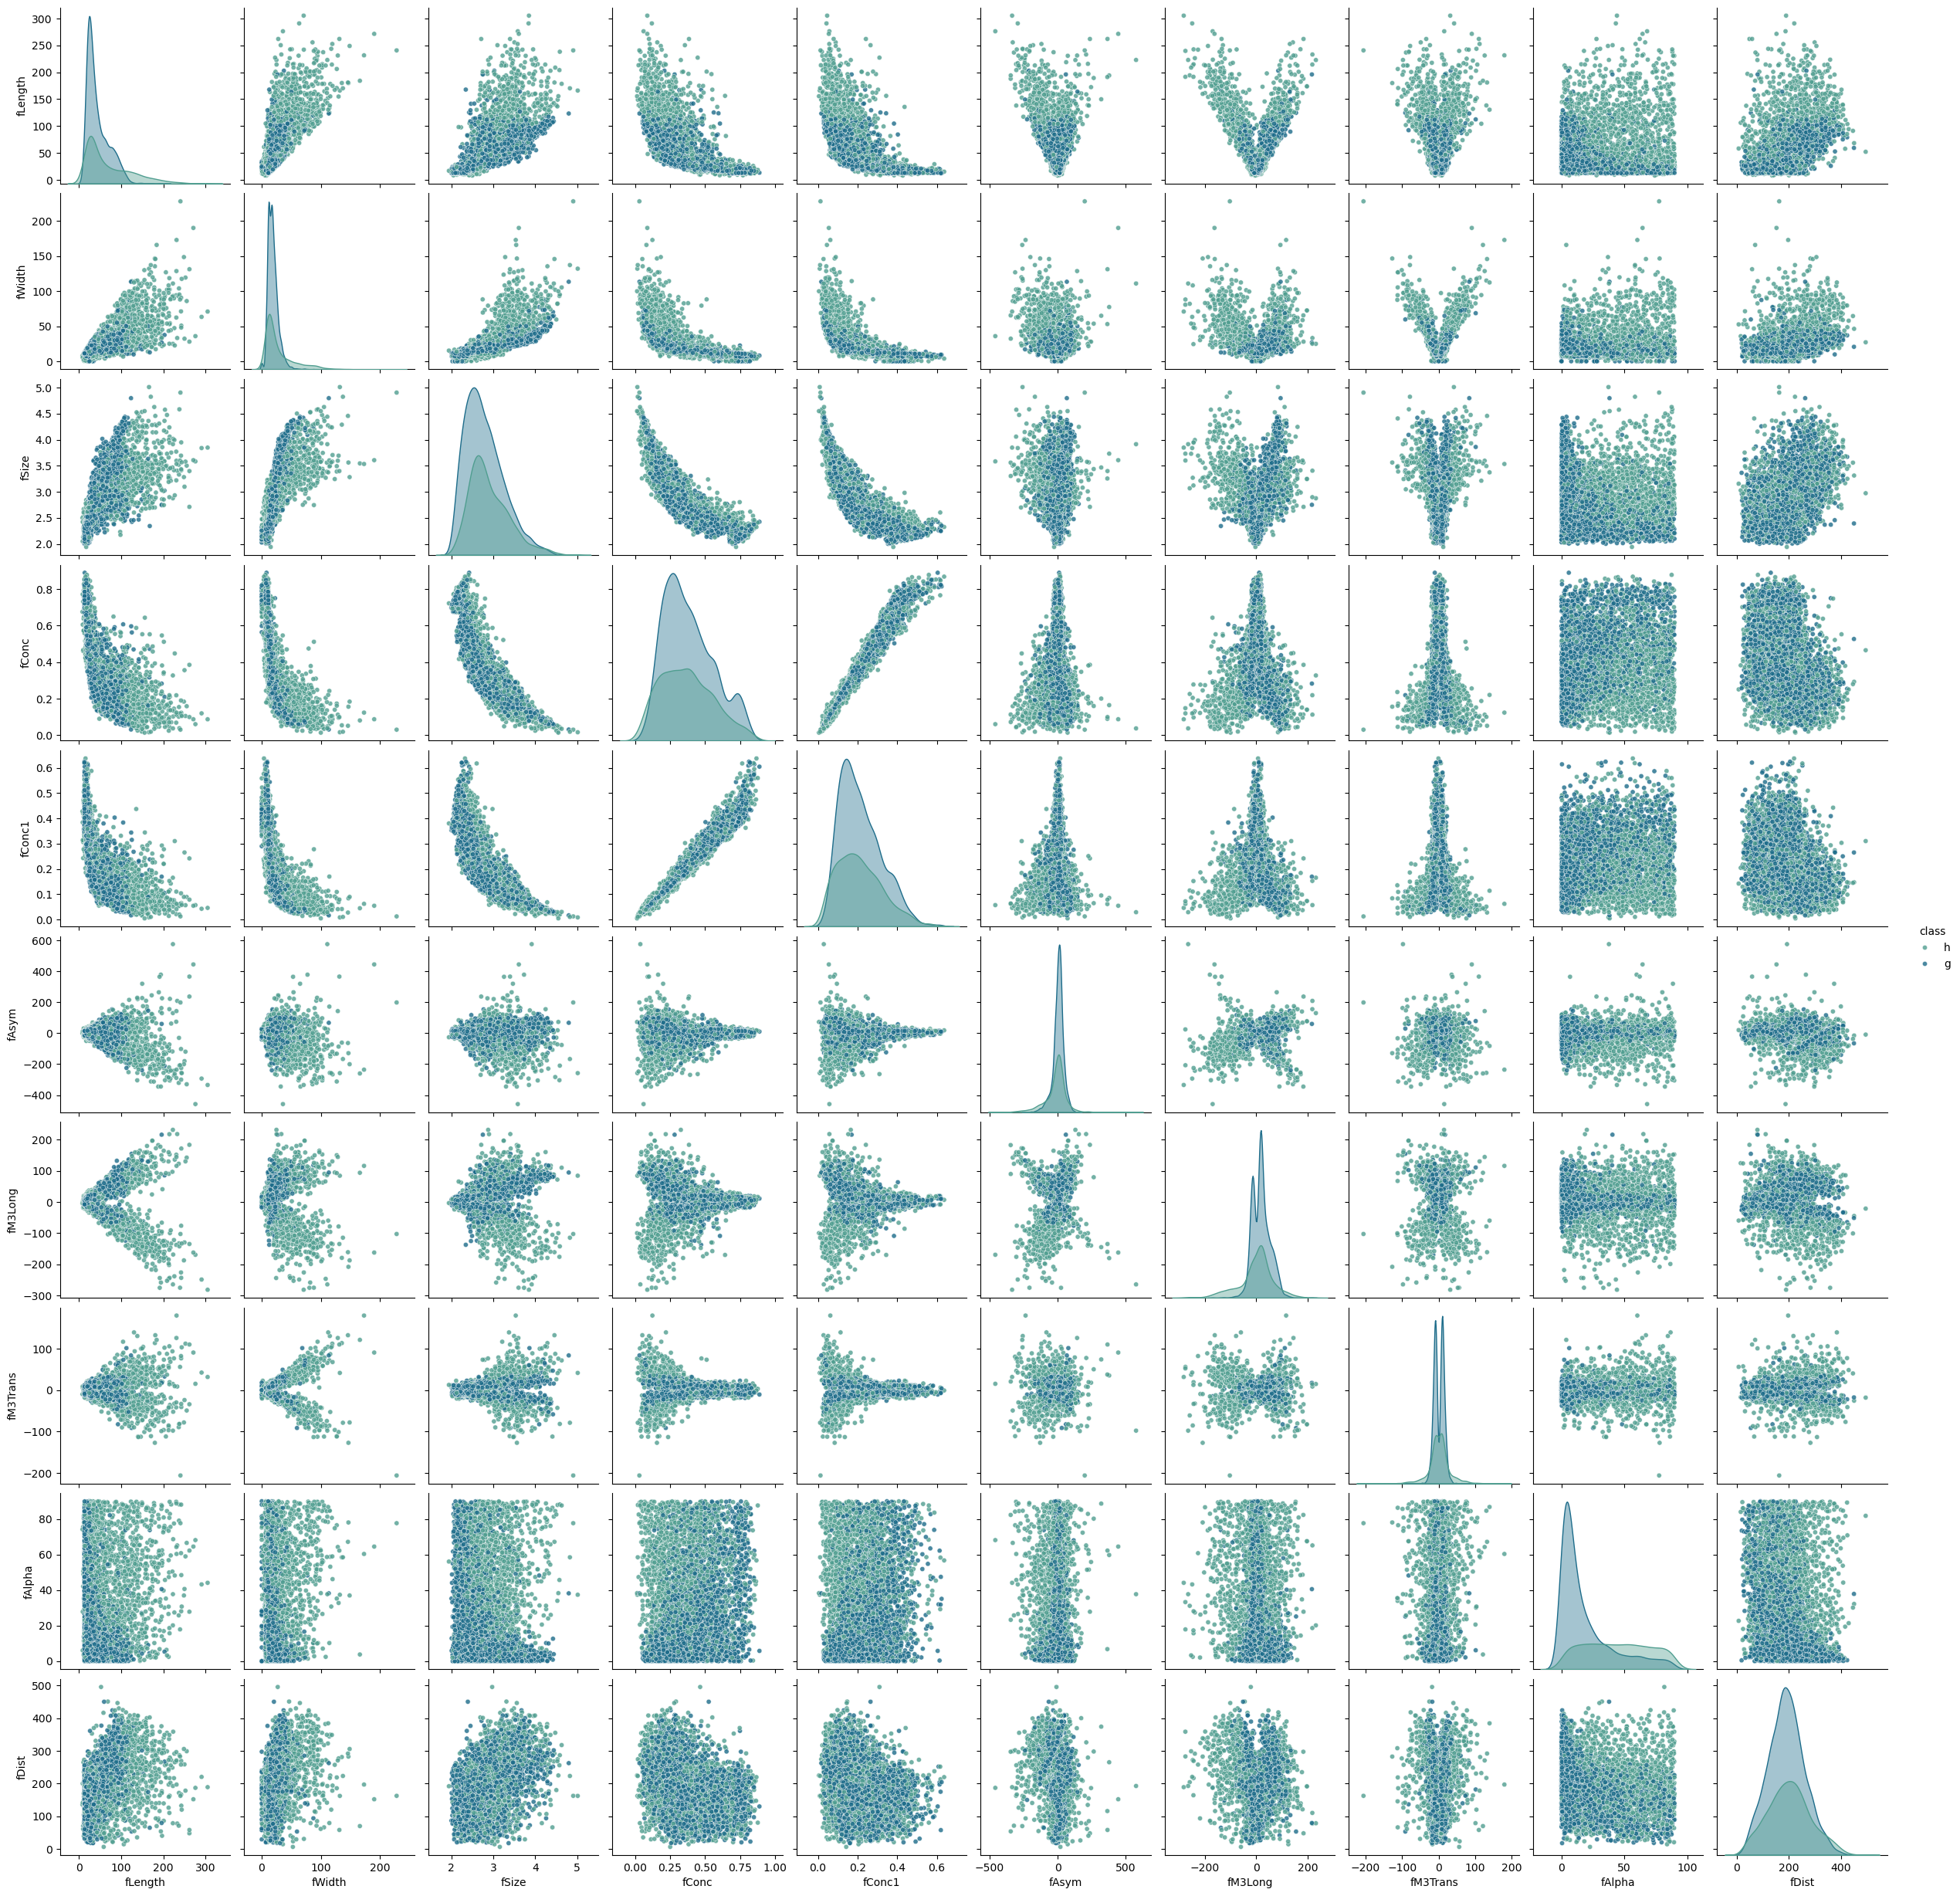

In [ ]:
# Pair Plotting a smaller subset of the data for easy visualization
df_compact = df.sample(n=6000, random_state=0)   

palette = sns.color_palette("crest", 2)

sns.pairplot(df_compact, hue='class', palette=palette,
             plot_kws={'alpha': 0.8, 's': 20},
             diag_kws={'alpha': 0.4})

In [5]:
# Separate features and target variable

X = df.drop('class', axis=1)
y = df['class']

# Encode the target labels

enc = LabelEncoder()
enc.fit(df['class'])
y = enc.transform(df['class'])

for i, label in enumerate(enc.classes_):
    print(f"{label}: {i}")

# Since we are using a RadomForest, scaling is not strictly necessary.

# Create a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,stratify=y)

# Pipeline with RandomOverSampler and RandomForestClassifier

# As there is a class imbalance, perform random oversampling for the minority class to prevent bias 
pipeline = Pipeline([
    ('ros', RandomOverSampler(random_state=0)),
    ('rf', RandomForestClassifier(class_weight='balanced'))
])

g: 0
h: 1


In [6]:
pipeline

Pipeline(steps=[('oversampler', RandomOverSampler(random_state=0)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [ ]:
# Use RandomizedSearchCV for hyperparameter tuning over GridSearchCV for faster convergence

param_grid = {
    'rf__n_estimators': [100, 200, 300, 400, 500,600, 700, 800],
    "rf__max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None],
    "rf__min_samples_split": [2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "rf__min_samples_leaf": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "rf__max_features": ["sqrt", "log2"]
}

grid = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = param_grid,
    scoring='f1',#q_scorer,
    cv=5,
    n_jobs=-1,
    verbose = True,
    n_iter=50,
)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/shahjahan/anaconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/shahjahan/anaconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/t

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ros',
                                              RandomOverSampler(random_state=0)),
                                             ('rf',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rf__max_depth': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12,
                                                          None],
                                        'rf__max_features': ['sqrt', 'log2'],
                                        'rf__min_samples_leaf': [2, 3, 4, 5, 6,
                                                                 7, 8, 9, 10],
                                        'rf__min_samples_split': [2, 3, 4, 5, 6,
                                                                  7, 8, 9, 10,
                                                                  11, 12, 13,
                                                                  14, 15],
                                        'rf__n_estimators': [100, 200, 300, 400,
                                                             500, 600, 700, 800,
                                                             900, 1000]},
                   scoring='f1', verbose=True)

In [7]:
print("Best parameters:", grid.best_params_)
print("Best cross-val score:", grid.best_score_)

Best parameters: {'rf__n_estimators': 700, 'rf__min_samples_split': 14, 'rf__min_samples_leaf': 7, 'rf__max_features': 'sqrt', 'rf__max_depth': None}
Best cross-val score: 0.8131389987750808


In [8]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomOverSampler(random_state=0)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=7,
                                        min_samples_split=14,
                                        n_estimators=700))])

In [9]:
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

Accuracy: 87.72%       	Recall: 90.98%      	Precision: 90.16%      	F1 Score: 90.57%


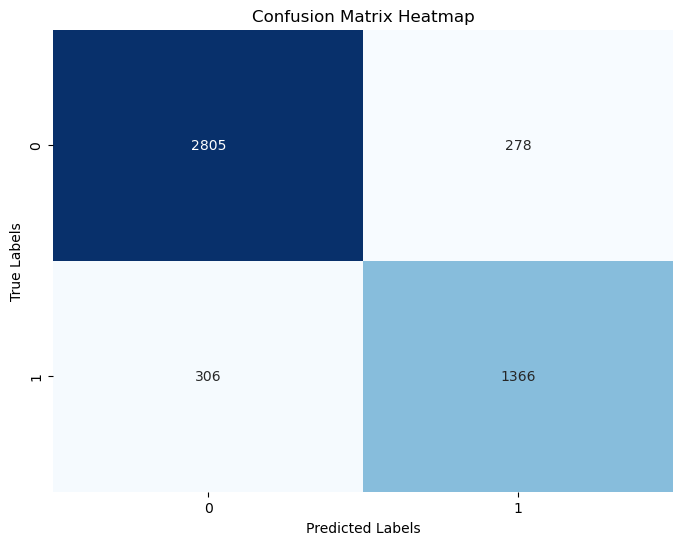

In [10]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label=0)
precision = precision_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label=0)

print(f'Accuracy: {accuracy * 100:.2f}% \
      \tRecall: {recall * 100:.2f}%\
      \tPrecision: {precision * 100:.2f}%\
      \tF1 Score: {f1 * 100:.2f}%'
      )

conf_matrix = confusion_matrix(y_test, y_pred)
ticks = sklearn.utils.multiclass.unique_labels(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=ticks, yticklabels= ticks)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

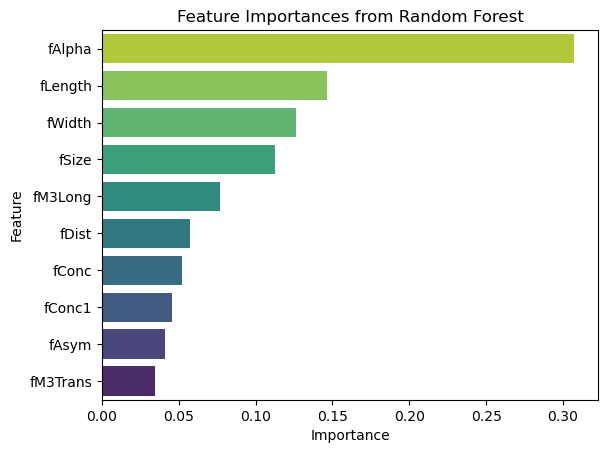

In [11]:
feature_importances = best_model.named_steps['rf'].feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis_r', hue = 'Feature', legend = False)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [66]:
'''plt.hist(df[df['class']=='g']['fDist'], bins=50, alpha=0.5, label='Gamma', color='blue')
plt.hist(df[df['class']=='h']['fDist'], bins=50, alpha=0.5, label='Gamma', color='blue')'''

"plt.hist(df[df['class']=='g']['fDist'], bins=50, alpha=0.5, label='Gamma', color='blue')\nplt.hist(df[df['class']=='h']['fDist'], bins=50, alpha=0.5, label='Gamma', color='blue')"

In [12]:
ind = np.argwhere(y_pred == 0) #Indices where predicted class is gamma
actual_gamma = np.argwhere((y_pred == 0) & (y_test == 0)) #Indices where predicted class is gamma and true class is also gamma  
true_gamma_count = np.sum(y_test == 0)
actual_hadron = np.argwhere((y_pred == 1) & (y_test == 1)) #Indices where predicted class is hadron and true class is also hadron
true_hadron_count = np.sum(y_test == 1)
false_gamma = np.argwhere((y_pred == 1) & (y_test == 0)) #Indices where predicted class is hadron but true class is gamma
print(f"Total predicted gamma events: {len(ind)}")
print(f"Total true gamma events correctly predicted: {len(actual_gamma)} out of {true_gamma_count}")
print(f"Total true hadron events correctly predicted: {len(actual_hadron)} out of {true_hadron_count}")
print(f"Total gamma events misclassified as hadrons: {len(false_gamma)} out of {np.sum(y_test == 0)}\n")

epsilon_gamma = np.round(np.sum((y_pred == 0) & (y_test == 0)) / true_gamma_count, 2)
hadron_leakage = np.round(np.sum((y_pred == 0) & (y_test == 1)) / true_hadron_count, 2)
epsilon_hadron = np.round(np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1), 2)
Q = np.round(epsilon_gamma / np.sqrt(hadron_leakage), 2)

print(f"e_gamma: {epsilon_gamma*100}%")
print(f"Hadron leakage: {hadron_leakage *100}%")
print(f"e_hadron: {epsilon_hadron*100}%\n")

print(f"Q factor: {Q}")  

Total predicted gamma events: 3111
Total true gamma events correctly predicted: 2805 out of 3083
Total true hadron events correctly predicted: 1366 out of 1672
Total gamma events misclassified as hadrons: 278 out of 3083

e_gamma: 91.0%
Hadron leakage: 18.0%
e_hadron: 82.0%

Q factor: 2.14


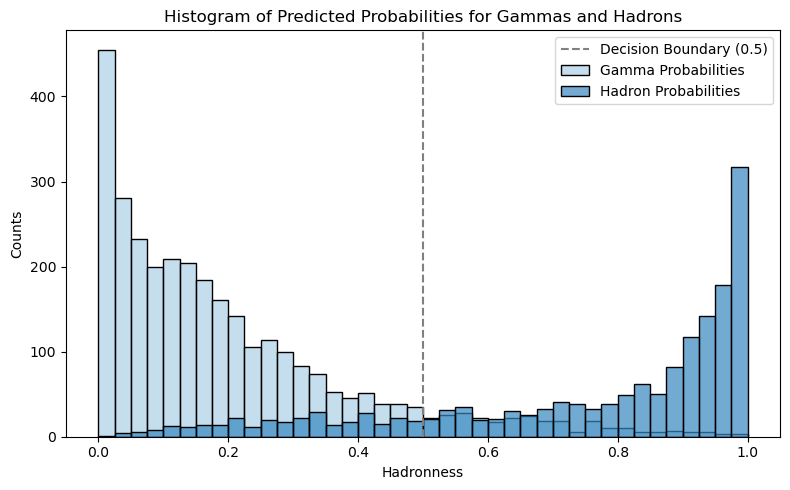

In [13]:
# Take test samples of pure gammas and pure hadrons to calculate probs and plot them

gamma_mask = y_test == 0
hadron_mask = y_test == 1 

gamma_probs = best_model.predict_proba(X_test[gamma_mask])[:,1]
hadron_probs = best_model.predict_proba(X_test[hadron_mask])[:,1]

palette = sns.color_palette("Blues", 2)
bins = np.linspace(0, 1, 41)   # same 40 bins as before

plt.figure(figsize=(8, 5))
sns.histplot(gamma_probs, bins=bins, stat='count',
             color=palette[0], alpha=0.7, label='Gamma Probabilities', kde=False)
sns.histplot(hadron_probs, bins=bins, stat='count',
             color=palette[1], alpha=0.7, label='Hadron Probabilities', kde=False)

plt.xlabel('Hadronness')
plt.ylabel('Counts')
plt.axvline(0.5, color='grey', linestyle='--', label='Decision Boundary (0.5)')
plt.title('Histogram of Predicted Probabilities for Gammas and Hadrons')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Check hadron contamination and gamma efficiency beyond the decision boundary
threshold = 0.5
probs = best_model.predict_proba(X_test)[:,0]
cutoff_probs = probs >= threshold
gamma_eff = np.round(np.sum((y_test[cutoff_probs]==0) & (y_pred[cutoff_probs]==0)) / np.sum(y_test == 0), 2) * 100
hadron_leak = np.round(np.sum((y_test[cutoff_probs]==1) & (y_pred[cutoff_probs]==0)) / np.sum(y_test == 1), 2) * 100

print(f"e_gamma(>0.5) = {gamma_eff}%")
print(f"Hadron leakage (>=0.5) = {hadron_leak}%")
print(f"Q(>=0.5) = {np.round(gamma_eff / np.sqrt(hadron_leak))}")

e_gamma(>0.5) = 91.0%
Hadron leakage (>=0.5) = 18.0%
Q(>=0.5) = 21.0
